#1. Import Libraries dan Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
byte_sequence = b'\x80\x81...'
decoded_string = byte_sequence.decode('utf-8', errors='ignore')
df=pd.read_csv("/content/drive/MyDrive/PKK/Tugas Akhir/spam.csv",encoding=('latin-1'))

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#2. Pra proses Data
* Data Cleaning
* Lower case
* Tokenization
* Removing special characters
* Removing stop words and punctuation
* Stemming


In [ ]:
print(df.shape)
print('==========')
print(df.info())

(5572, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


## 2.1 Data cleaning
Tahap ini bertujuan menghapus kolom, duplikasi, dan null yang ada

In [ ]:
# Hapus kolom
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis='columns',inplace=True)
# Ubah nama kolom
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
print("shape sebelum hapus duplikat", df.shape)
df = df.drop_duplicates(keep='first')
print("shape setelah hapus duplikat",df.shape)

shape sebelum hapus duplikat (5572, 2)
shape setelah hapus duplikat (5169, 2)


Ubah kelas ham jadi 0 dan spam jadi 1

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

<ipython-input-9-73b62026db78>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = encoder.fit_transform(df['target'])


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# cek apakah ada data null
print(f'{df.isnull().sum()}')

target    0
text      0
dtype: int64


##2.2 Visualisasi data spam dan ham after cleaning

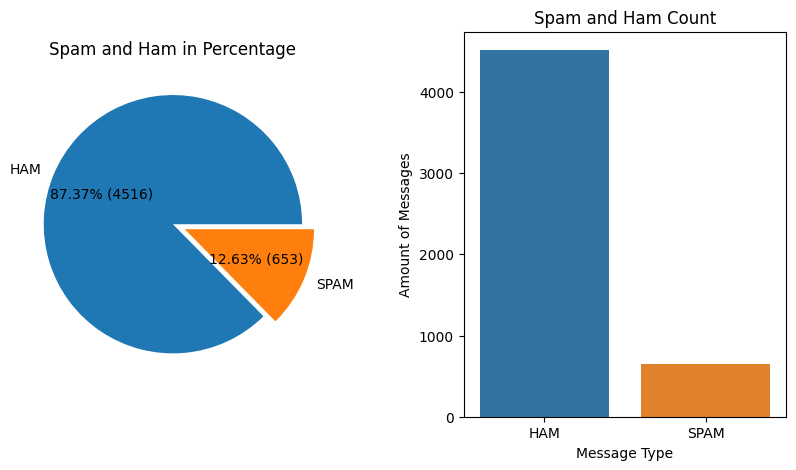

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts of each class
counts = df['target'].value_counts()
# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart
axs[0].pie(df['target'].value_counts(), explode=[0, 0.1], labels=['HAM', 'SPAM'], autopct=lambda p: f'{p:.2f}% ({int(p * sum(counts) / 100)})')
axs[0].set_title("Spam and Ham in Percentage")

# Bar plot
sns.barplot(x=['HAM', 'SPAM'], y=df['target'].value_counts(), ax=axs[1])
axs[1].set_title("Spam and Ham Count")
axs[1].set_xlabel("Message Type")
axs[1].set_ylabel("Amount of Messages")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the figure
plt.show()


In [ ]:
# df['num_characters'] = df['text'].apply(len)
# df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
# df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
# df.head()

# df.drop(['num_characters','num_words','num_sentences'],axis='columns',inplace=True)
# df.head()

##2.3 Transformasi Text Menggunakan NTLK

In [ ]:
def transform(text):
    # Remove whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)

    # LOWERCASE
    tokens = word_tokenize(text.lower())

    # Remove non-alphanumeric tokens
    tokens = [t for t in tokens if t.isalnum()]

    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english')+ ['u', 'im'])
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]

    # Stem the remaining tokens using PorterStemmer
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]

    # Join the tokens back into a string and return it
    return tokens


In [ ]:
print(f"{df['text'][10]}\n{transform(df['text'][10])}")

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
['gon', 'na', 'home', 'soon', 'dont', 'want', 'talk', 'stuff', 'anymor', 'tonight', 'k', 'ive', 'cri', 'enough', 'today']


In [ ]:
df['text'] = df['text'].apply(transform)

In [ ]:
df['text'] = df['text'].astype(str)

In [ ]:
df.head()

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."


In [ ]:
print(df['text'])

0       ['go', 'jurong', 'point', 'crazi', 'avail', 'b...
1                     ['ok', 'lar', 'joke', 'wif', 'oni']
2       ['free', 'entri', '2', 'wkli', 'comp', 'win', ...
3       ['dun', 'say', 'earli', 'hor', 'c', 'alreadi',...
4       ['nah', 'dont', 'think', 'goe', 'usf', 'live',...
                              ...                        
5567    ['2nd', 'time', 'tri', '2', 'contact', '750', ...
5568                ['b', 'go', 'esplanad', 'fr', 'home']
5569                 ['piti', 'mood', 'soani', 'suggest']
5570    ['guy', 'bitch', 'act', 'like', 'id', 'interes...
5571                             ['rofl', 'true', 'name']
Name: text, Length: 5169, dtype: object


#3. EDA

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

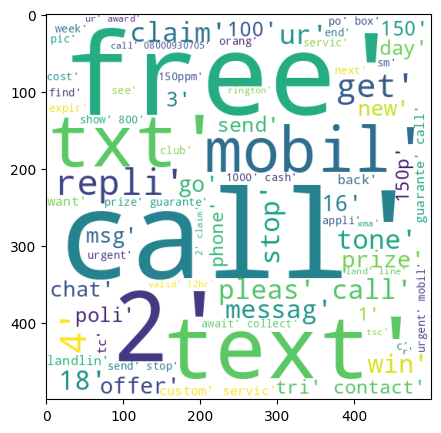

In [ ]:
spam_wc = wc.generate(df[df['target'] == 1]['text'].str.cat(sep=" "))
plt.figure(figsize=(5,5))
plt.imshow(spam_wc)

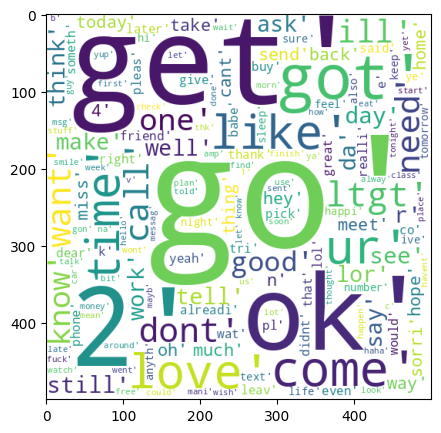

In [ ]:
ham_wc = wc.generate(df[df['target'] == 0]['text'].str.cat(sep=" "))
plt.figure(figsize=(5,5))
plt.imshow(ham_wc)

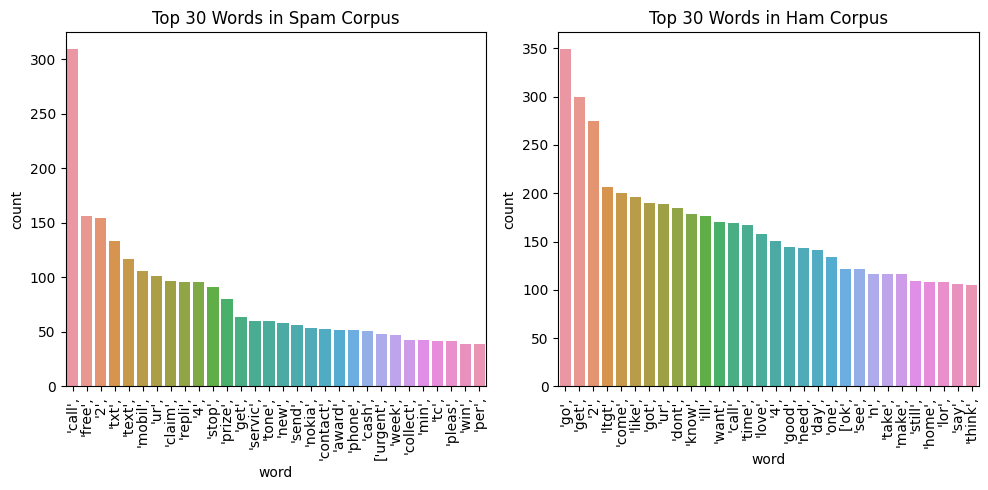

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Group by target and apply Counter to calculate word frequencies
word_freq_spam = Counter(df[df['target'] == 1]['text'].str.split().sum()).most_common(30)
word_freq_ham = Counter(df[df['target'] == 0]['text'].str.split().sum()).most_common(30)

# Create dataframes for plotting
word_freq_df_spam = pd.DataFrame(word_freq_spam, columns=['word', 'count'])
word_freq_df_ham = pd.DataFrame(word_freq_ham, columns=['word', 'count'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot for spam corpus
sns.barplot(data=word_freq_df_spam, x='word', y='count', ax=ax1)
ax1.set_title('Top 30 Words in Spam Corpus')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation='vertical')

# Plot for ham corpus
sns.barplot(data=word_freq_df_ham, x='word', y='count', ax=ax2)
ax2.set_title('Top 30 Words in Ham Corpus')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation='vertical')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#4. Imbalanced Data

In [ ]:
import pandas as pd

class_distribution = df['target'].value_counts()

print("Class distribution:")
print(class_distribution)

Class distribution:
0    4516
1     653
Name: target, dtype: int64


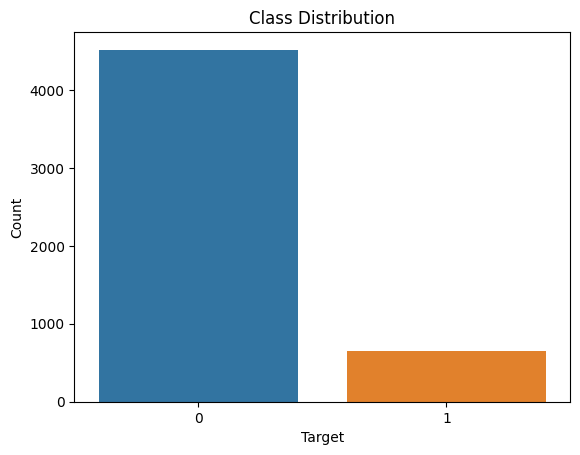

In [ ]:
sns.countplot(data=df, x='target')
plt.title("Class Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [ ]:
# df2 = df[['target', 'transformed_text']]
# df2.head(10)

**OVERSAMPLING DATA**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Separate features (X) and target variable (y)
x = df.drop('target', axis=1)  # Features excluding the target column
y = df['target']  # Target variable

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy = 'minority', random_state=42)

x_resampled, y_resampled = oversampler.fit_resample(x, y)

print("Class distribution after oversampling:")
print(y_resampled.value_counts())

Class distribution after oversampling:
0    4516
1    4516
Name: target, dtype: int64


**UNDERSAMPLING DATA**

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# # Separate features (X) and target variable (y)
# x = df.drop('target', axis=1)  # Features excluding the target column
# y = df['target']  # Target variable

# # Create an instance of RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# x_resampled, y_resampled = undersampler.fit_resample(x, y)

# print("Class distribution after undersampling:")
# print(y_resampled.value_counts())


In [ ]:
# x_resampled = np.array(x_resampled)
x_resampled

,text
0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...
9027,"['guarante', '1000', 'cash', '2000', 'prize', ..."
9028,"['1000', 'flirt', 'txt', 'girl', 'bloke', 'ur'..."
9029,"['80488', '500', 'free', 'text', 'messag', 'va..."
9030,"['wwwapplausestorecom', 'monthlysubscription50..."


In [ ]:
print(y_resampled[:5])

0    0
1    0
2    1
3    0
4    0
Name: target, dtype: int64


In [ ]:
# Combine X_resampled_df and y_resampled_df into a single DataFrame
df_os = pd.concat([y_resampled, x_resampled], axis=1)
# print(df2_os.shape)
# df2_os.drop(['text'],axis='columns',inplace=True)
df_os.head()

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."


In [ ]:
print(x_resampled.shape)  # Shape of X_resampled
print(y_resampled.shape)  # Shape of y_resampled

(9032, 1)
(9032,)


In [ ]:
# Assuming 'df' is your DataFrame containing the target column
class_distribution = df_os['target'].value_counts()

print("Class distribution:")
print(class_distribution)

Class distribution:
0    4516
1    4516
Name: target, dtype: int64


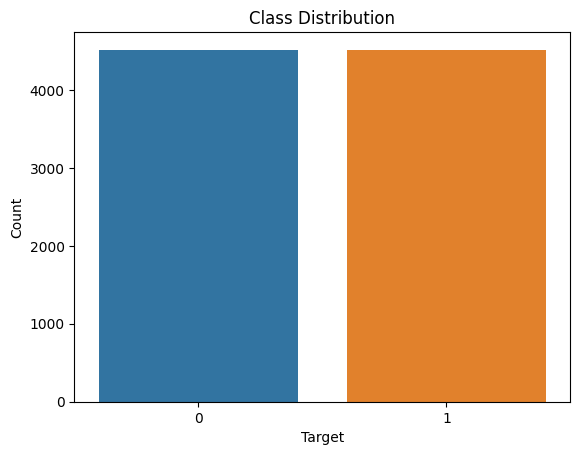

In [ ]:
sns.countplot(data=df_os, x='target')
plt.title("Class Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [ ]:
df_os

,target,text
0,0,"['go', 'jurong', 'point', 'crazi', 'avail', 'b..."
1,0,"['ok', 'lar', 'joke', 'wif', 'oni']"
2,1,"['free', 'entri', '2', 'wkli', 'comp', 'win', ..."
3,0,"['dun', 'say', 'earli', 'hor', 'c', 'alreadi',..."
4,0,"['nah', 'dont', 'think', 'goe', 'usf', 'live',..."
...,...,...
9027,1,"['guarante', '1000', 'cash', '2000', 'prize', ..."
9028,1,"['1000', 'flirt', 'txt', 'girl', 'bloke', 'ur'..."
9029,1,"['80488', '500', 'free', 'text', 'messag', 'va..."
9030,1,"['wwwapplausestorecom', 'monthlysubscription50..."


In [ ]:
# from nltk.tokenize import word_tokenize
# df2_os['transformed_text'] = df2_os['transformed_text'].apply(word_tokenize)
# print(df2_os['transformed_text'])

#5. Building Model

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

labels=df_os["target"]
encoded_data = label_encoder.fit_transform(labels)
labels=encoded_data
encoded_data

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
labels.shape

(9032,)

In [ ]:
text = df_os['text']
text.shape

(9032,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

In [ ]:
X_train

2766    ['must', 'sit', 'around', 'wait', 'summer', 'd...
2484    ['gon', 'na', 'abl', 'late', 'notic', 'ill', '...
5246    ['free', 'ring', 'tone', 'text', 'poli', '8713...
7888    ['r', 'subscrib', '2', 'textcomp', '250', 'wkl...
970     ['wan', 'come', 'come', 'lor', 'din', 'c', 'st...
                              ...                        
5734    ['free', 'rington', 'text', 'first', '87131', ...
5191    ['sexi', 'singl', 'wait', 'text', 'age', 'foll...
5390    ['sparkl', 'shop', 'break', '45', 'per', 'pers...
860     ['secret', 'admir', 'look', '2', 'make', 'cont...
7270    ['1st', 'wk', 'free', 'gr8', 'tone', 'str8', '...
Name: text, Length: 7225, dtype: object

In [ ]:
y_train

array([0, 0, 1, ..., 1, 1, 1])

In [77]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_layer = Embedding(vocab_size, embedding_dim)

train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

[[384, 1113, 264, 64, 385, 35, 1535, 3515, 3086, 437, 2695, 2346, 4187, 210, 1211], [351, 107, 673, 326, 889, 73, 103, 22, 651, 352], [3, 455, 17, 6, 104, 674, 71, 22, 7, 15, 17, 1536, 1537], [61, 464, 2, 1775, 168, 279, 378, 128, 180, 3, 316, 265, 1776, 180, 1777, 183, 5, 11, 2, 1778, 675], [123, 40, 40, 108, 1538, 92, 4188, 4189], [236, 426, 1212, 153, 2038, 30, 323, 264], [13, 2347, 28, 3516, 1779, 42], [6, 222, 551, 11, 144, 600], [270, 4, 19, 57, 223, 78, 1213, 46, 3, 132, 2, 65, 279, 72, 5, 176, 254], [2696, 7, 400, 37, 232, 2697, 101, 299, 232, 50, 1310, 273, 438, 37, 145, 481], [359, 764, 4190, 4191, 4192, 1539, 844, 184, 4193, 4194, 3517, 4195, 101], [20, 9, 38, 19, 70, 14, 46, 1, 800, 161, 58, 12, 353, 137, 187, 109], [116, 19, 740, 401, 116, 1, 1114, 1115, 83, 150, 583, 845, 35], [633, 504, 1780, 226, 601, 164], [2348, 4196, 2349, 514, 75, 3087, 191, 1311, 2350, 2346, 3518], [652, 274, 765, 41, 710, 766, 95, 2698, 393, 123, 764, 274, 427, 482], [3, 132, 3088, 279, 378, 8, 11

In [ ]:
train_sequences

array([[ 384, 1113,  264, ...,    0,    0,    0],
       [ 351,  107,  673, ...,    0,    0,    0],
       [   3,  455,   17, ...,    0,    0,    0],
       ...,
       [2323,  174,  416, ...,    0,    0,    0],
       [ 338,  365,  186, ...,    0,    0,    0],
       [ 128,  180,    3, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Buat model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(0.5))
# model.add(Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          726500    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                        

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(train_sequences,
                    y_train,
                    validation_data=(test_sequences, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

loss, accuracy = model.evaluate(test_sequences, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
226/226 [==============================] - 14s 54ms/step - loss: 0.6548 - accuracy: 0.8466 - val_loss: 0.2002 - val_accuracy: 0.9768
Epoch 2/10
226/226 [==============================] - 12s 52ms/step - loss: 0.1568 - accuracy: 0.9853 - val_loss: 0.0878 - val_accuracy: 0.9956
Epoch 3/10
226/226 [==============================] - 12s 53ms/step - loss: 0.0840 - accuracy: 0.9947 - val_loss: 0.0522 - val_accuracy: 0.9978
Epoch 4/10
226/226 [==============================] - 12s 53ms/step - loss: 0.0535 - accuracy: 0.9982 - val_loss: 0.0462 - val_accuracy: 0.9950
Epoch 5/10
226/226 [==============================] - 11s 50ms/step - loss: 0.0440 - accuracy: 0.9989 - val_loss: 0.0356 - val_accuracy: 0.9972
Epoch 6/10
226/226 [==============================] - 11s 46ms/step - loss: 0.0346 - accuracy: 0.9982 - val_loss: 0.0261 - val_accuracy: 0.9983
Epoch 7/10
226/226 [==============================] - 12s 54ms/step - loss: 0.0308 - accuracy: 0.9985 - val_loss: 0.0227 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

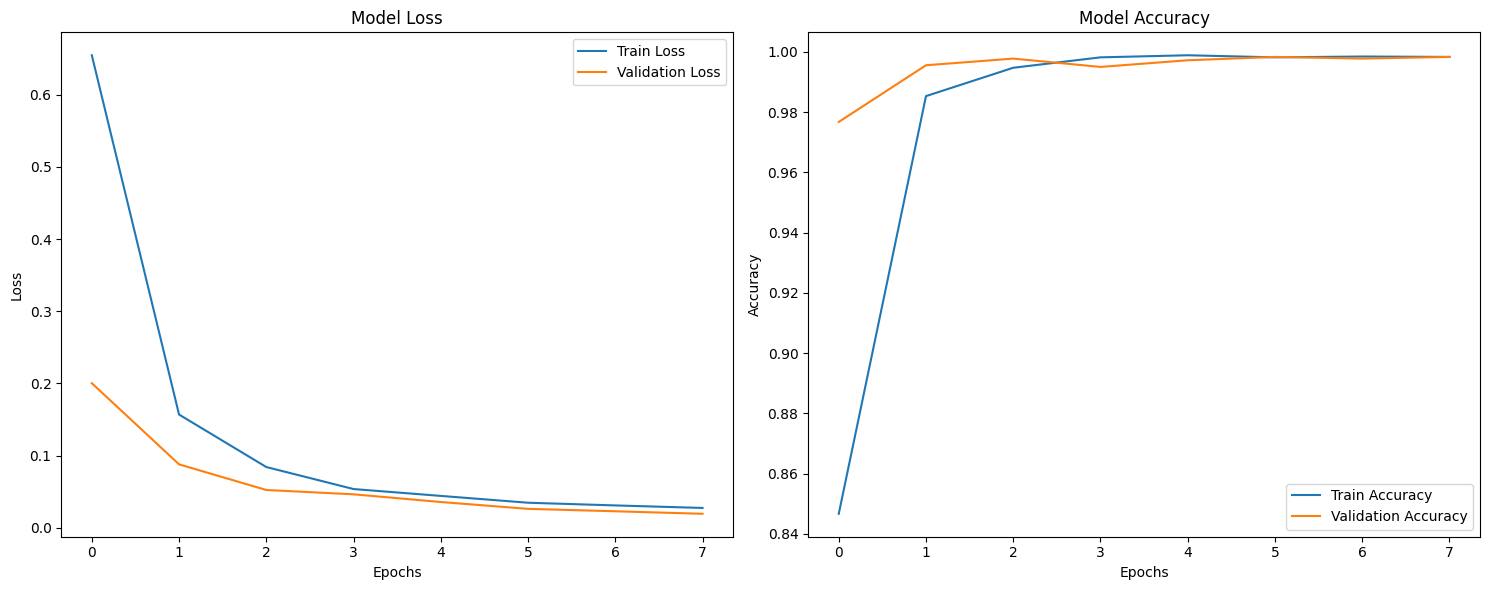

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot model loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot model accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the combined plot
plt.show

In [ ]:
model.evaluate(test_sequences, y_test)

57/57 [==============================] - 1s 11ms/step - loss: 0.0356 - accuracy: 0.9972


[0.035552315413951874, 0.997232973575592]

In [ ]:
X_test_array = np.array(test_sequences)
y_preds = model.predict(X_test_array)
y_preds

57/57 [==============================] - 1s 10ms/step


array([[1.4064148e-04],
       [1.0000000e+00],
       [9.9999976e-01],
       ...,
       [8.3215940e-01],
       [9.9999952e-01],
       [1.3966937e-04]], dtype=float32)

In [ ]:
print(X_test_array.shape)

(1807, 100)


In [ ]:
X_test

2373                             ['mm', 'way', 'railway']
8209    ['urgent', 'mobil', 'award', '1500', 'bonu', '...
8993    ['hi', 'sexychat', 'girl', 'wait', 'text', 'te...
5239    ['summer', 'final', 'fanci', 'chat', 'flirt', ...
6013    ['2nd', 'attempt', 'contract', 'week', 'top', ...
                              ...                        
8722    ['dont', 'prize', 'go', 'anoth', 'custom', 'tc...
1281        ['sent', 'scream', 'moan', 'bed', 'princess']
971     ['xma', 'stori', 'peac', 'xma', 'msg', 'love',...
8584    ['gr8', 'poli', 'tone', '4', 'mob', 'direct', ...
4478             ['dont', 'know', 'she', 'get', 'messag']
Name: text, Length: 1807, dtype: object

In [ ]:
X_test_array

array([[1501,  222, 3719, ...,    0,    0,    0],
       [  20,    9,   19, ...,    0,    0,    0],
       [  89, 3023,  179, ...,    0,    0,    0],
       ...,
       [ 177,  926, 3186, ...,    0,    0,    0],
       [ 370,  104,   17, ...,    0,    0,    0],
       [  28,   30,  667, ...,    0,    0,    0]], dtype=int32)

In [ ]:
from sklearn.metrics import confusion_matrix

y_preds = (model.predict(X_test_array) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_preds)
print(cm)

57/57 [==============================] - 1s 19ms/step
[[879   5]
 [  0 923]]


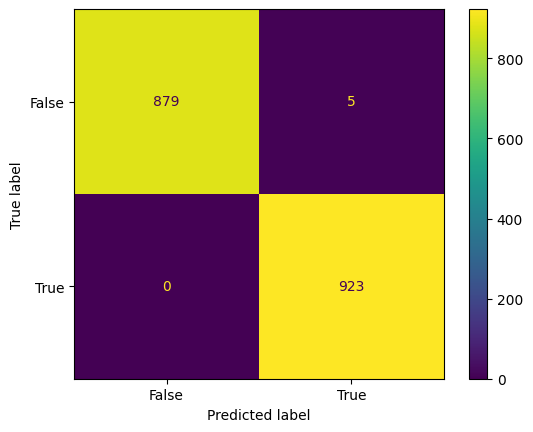

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(y_test, y_preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#Make Predictions

In [79]:
def transform_sms(text):
    # Remove whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Remove special characters
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)

    # LOWERCASE
    tokens = word_tokenize(text.lower())

    # Remove non-alphanumeric tokens
    tokens = [t for t in tokens if t.isalnum()]

    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english')+ ['u', 'im'])
    punctuation_set = set(string.punctuation)
    tokens = [t for t in tokens if t not in stopwords_set and t not in punctuation_set]

    # Stem the remaining tokens using PorterStemmer
    ps = PorterStemmer()
    tokens = [ps.stem(t) for t in tokens]

    # print(tokens)


    # Join the tokens back into a string and return it
    return tokens

def preprocess_input(input_text):
    cleaned_text = transform_sms(input_text)
    preprocessed_text = tokenizer.texts_to_sequences([cleaned_text])
    preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length)
    print(preprocessed_text)
    cleaned_text = model.predict
    # print(cleaned_text)
    return cleaned_text

input_text = "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it s..."
# transform_sms(input_text)
# preprocess_input(input_text)

res = preprocess_input(input_text)
# prediction = model.predict(preprocessed_input)[0][0]
# prediction

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [78]:
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences

def clean_text(text):
    # Mengubah teks menjadi lowercase
    text = text.lower()

    # Menghapus karakter yang tidak diperlukan
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca

    # Tokenisasi teks menjadi kata-kata
    words = text.split()

    # Menggabungkan kata-kata menjadi teks kembali
    cleaned_text = ' '.join(words)

    # Menghapus whitespace berlebih
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    print(cleaned_text)

    return cleaned_text

# Tahap cleaning dan preprocessing input
def preprocess_input(input_text):
    cleaned_text = transform(input_text)
    preprocessed_text = tokenizer.texts_to_sequences([cleaned_text])
    print(preprocessed_text)
    preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length)
    return preprocessed_text

# Meminta input dari pengguna
input_text = "Nah I don't think he goes to usf, he lives around here though"
clean_text(input_text)

# Melakukan tahap cleaning dan preprocessing pada input
preprocessed_input = preprocess_input(input_text)


nah i dont think he goes to usf he lives around here though
[[]]


In [64]:
# Meminta input dari pengguna
input_text = input("Masukkan teks untuk diprediksi: ")

# Melakukan tahap cleaning dan preprocessing pada input
preprocessed_input = preprocess_input(input_text)

# Melakukan prediksi pada inputan pengguna
prediction = model.predict(preprocessed_input)[0][0]
prediction

Masukkan teks untuk diprediksi: Nah I don't think he goes to usf, he lives around here though
nah i dont think he goes to usf he lives around here though
1/1 [==============================] - 0s 25ms/step


0.0017750849